In [1]:
import os
import numpy as np
#from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
#import nilearn
#from nilearn import plotting
#from nilearn import image

In [2]:
from nilearn import datasets

ModuleNotFoundError: No module named 'nilearn'

#### Loading files

In [3]:
example_file = os.path.join('..','data','MICCAI_BraTS2020_TrainingData','BraTS20_Training_129','BraTS20_Training_129_flair.nii.gz')

In [4]:
img = nib.load(example_file)
imgarr = img.get_fdata()

In [7]:
np.max(imgarr[:,:,9])

599.0

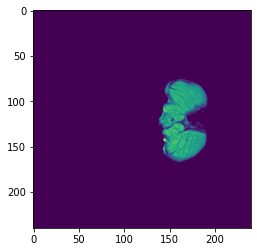

In [6]:
plt.imshow(imgarr[:,:,9])

#### Atlas

In [37]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps


Dataset created in C:\Users\pablo/nilearn_data\fsl



Downloaded 25716861 of 25716861 bytes (100.0%,    0.0s remaining) ...done. (141 seconds, 2 min)
Extracting data from C:\Users\pablo/nilearn_data\fsl\e76a8cdb5571906307e94c1d8c134604\HarvardOxford.tgz..... done.


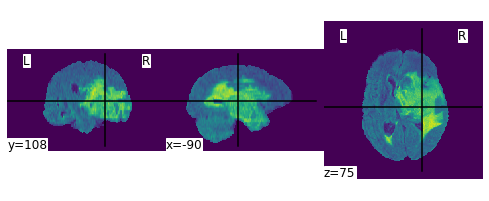

In [115]:

#plotting.view_img(atlas_filename)
plotting.plot_img(img) #for 3D volumes
#plotting.show()

#### Functions for image visualization:

plotting.plot_img(path/img)

plotting.plot_anat(path/img)

plotting.plot_roi() #meh, not bad

plotting.view_img() #interactive visualization, more or less

#### Operations:

image.smooth_img() #indicate the filter

image.mean_img()

image.get_data() #get numpy array

plotting.plot_anat(mean_img, display_mode='y', cut_coords=[108])  #For specific slices visualization

In [45]:
smooth_img_ = image.smooth_img(example_file, fwhm=3)

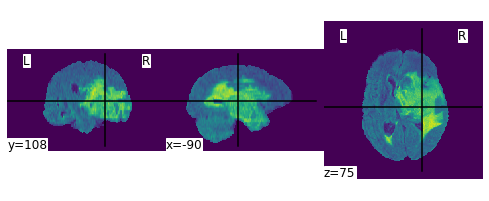

In [117]:
test1 = plotting.plot_img(img)


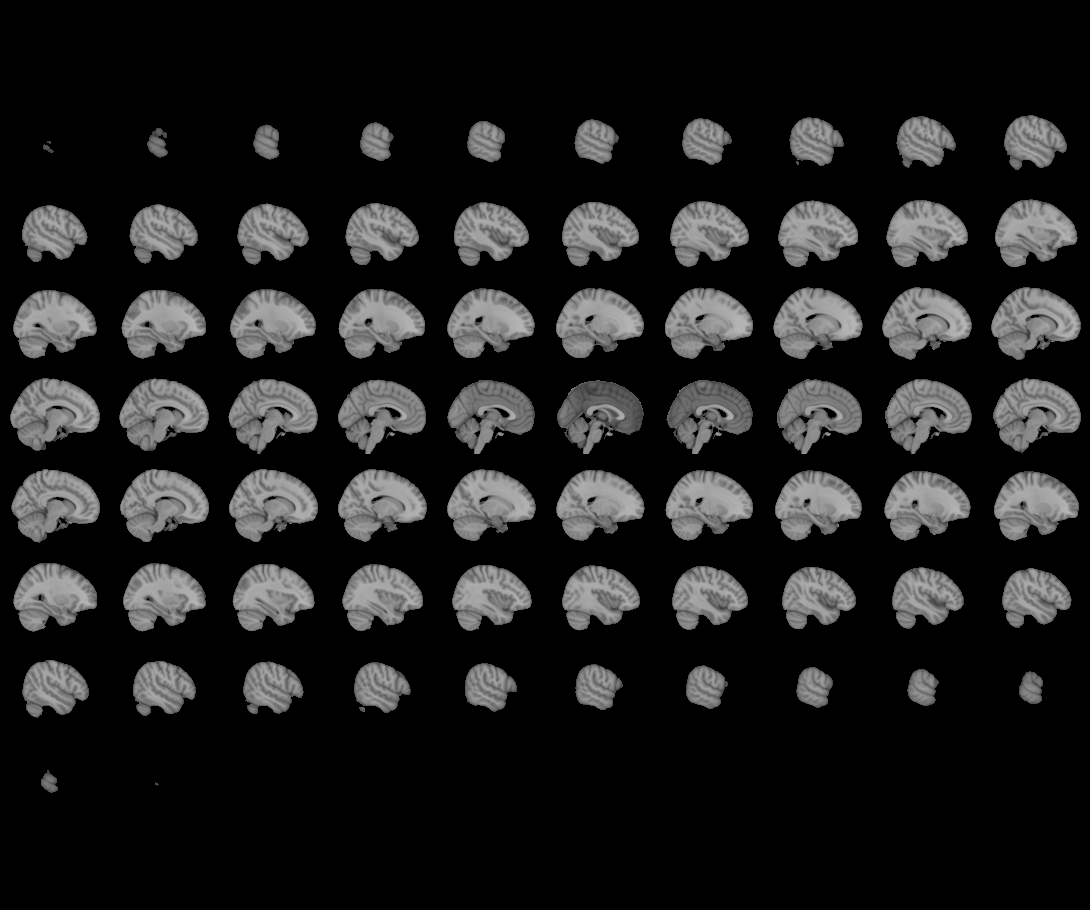
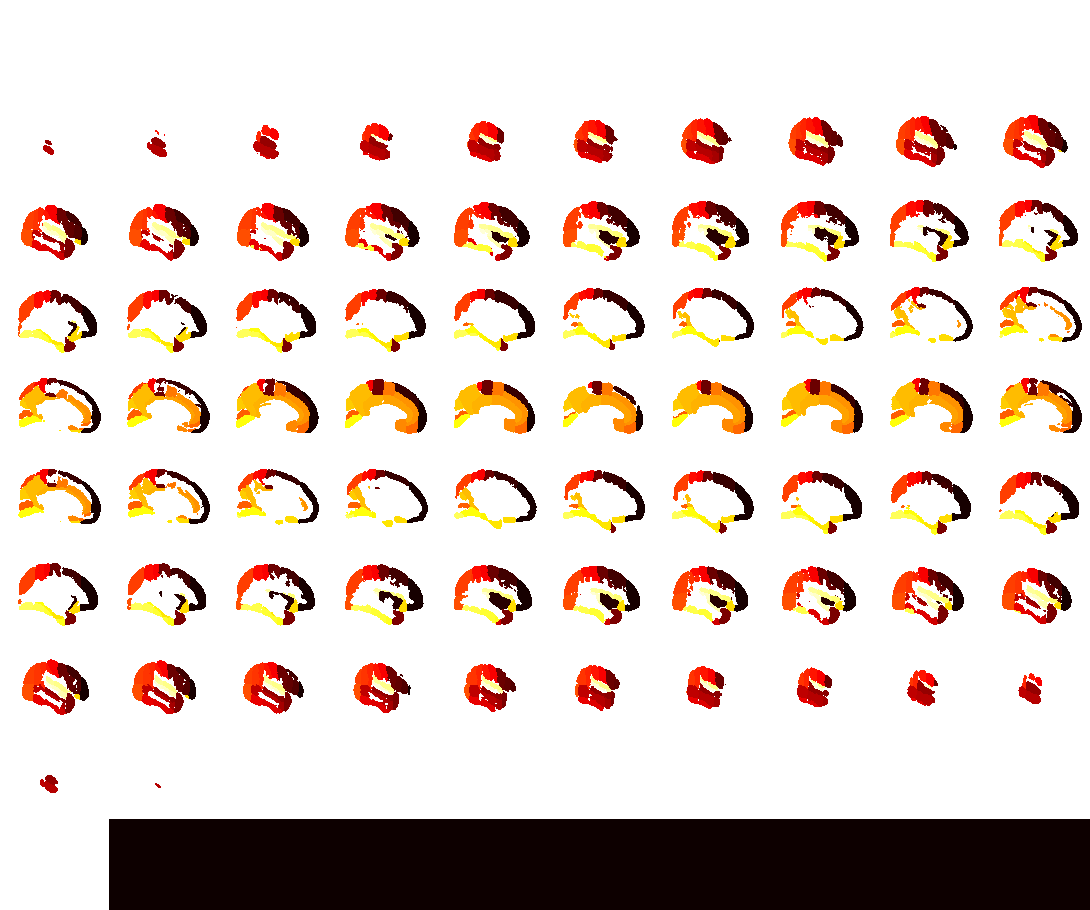

In [94]:
plotting.view_img(atlas_filename)

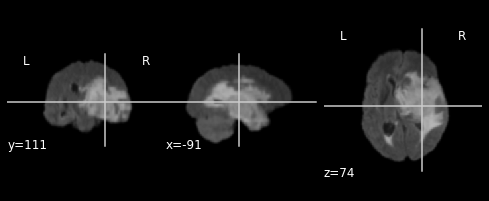

In [48]:
plotting.plot_anat(smooth_img_)

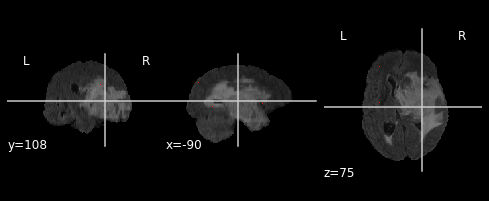

In [77]:
mean_img = image.mean_img(example_file)
display = plotting.plot_anat(mean_img)
display.add_edges(mean_img)
plotting.show()

In [71]:
edgy = display.add_edges(smooth_img_) ## do not really understand how it works

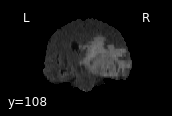

In [87]:
display = plotting.plot_anat(mean_img, display_mode='y', cut_coords=[108])

In [89]:
img_np = image.get_data(mean_img)

##### Doubts

dibujar cuadros y puntos con referencia a los centros de las imagenes

images as a function of mm??

## NIBABEL

In [96]:
img = nib.load(example_file)

In [98]:
header = img.header
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 239.0
qoffset_z       : 0.0
srow_x          : [-1. -0. -0.  0.]
srow_y          : 

In [104]:
anat_img_data = img.get_fdata()
anat_img_data.shape

(240, 240, 155)

Text(0.5, 0.98, 'Center slices for EPI image')

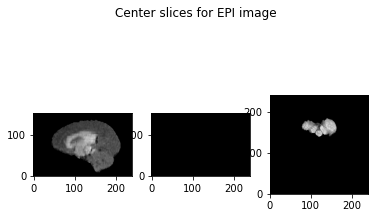

In [103]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = anat_img_data[106, :, :]
slice_1 = anat_img_data[:, 30, :]
slice_2 = anat_img_data[:, :, 16]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

In [106]:
cropped_img = img.slicer[32:-32, ...]
cropped_img.shape

(176, 240, 155)

In [108]:
n_i, n_j, n_k = anat_img_data.shape
center_i = (n_i - 1) // 2  # // for integer division
center_j = (n_j - 1) // 2
center_k = (n_k - 1) // 2
center_i, center_j, center_k

(119, 119, 77)

In [107]:
center_vox_value = anat_img_data[center_i, center_j, center_k]
center_vox_value

340.0

We have an anatomical and an EPI scan, and later on we will surely want to be able to relate the data from `someones_epi.nii.gz` to `someones_anatomy.nii.gz`. We can’t easily do this at the moment, because we collected the anatomical image with a different field of view and orientation to the EPI image, so the voxel coordinates in the EPI image refer to different locations in the magnet to the voxel coordinates in the anatomical image.

We solve this problem by keeping track of the relationship of voxel coordinates to some reference space. In particular, the affine array stores the relationship between voxel coordinates in the image data array and coordinates in the reference space. We store the relationship of voxel coordinates from `someones_epi.nii.gz` and the reference space, and also the (different) relationship of voxel coordinates in `someones_anatomy.nii.gz` to the same reference space. Because we know the relationship of (voxel coordinates to the reference space) for both images, we can use this information to relate voxel coordinates in `someones_epi.nii.gz` to spatially equivalent voxel coordinates in `someones_anatomy.nii.gz`.

Call the first axis the “X” axis, the second “Y” and the third “Z”. A coordinate of (x,y,z)=(10,−5,−3) in this space refers to the point in space 10mm to the (fictional observer’s) right of isocenter, 5mm towards the floor from the isocenter, and 3mm towards the foot of the scanner bed.

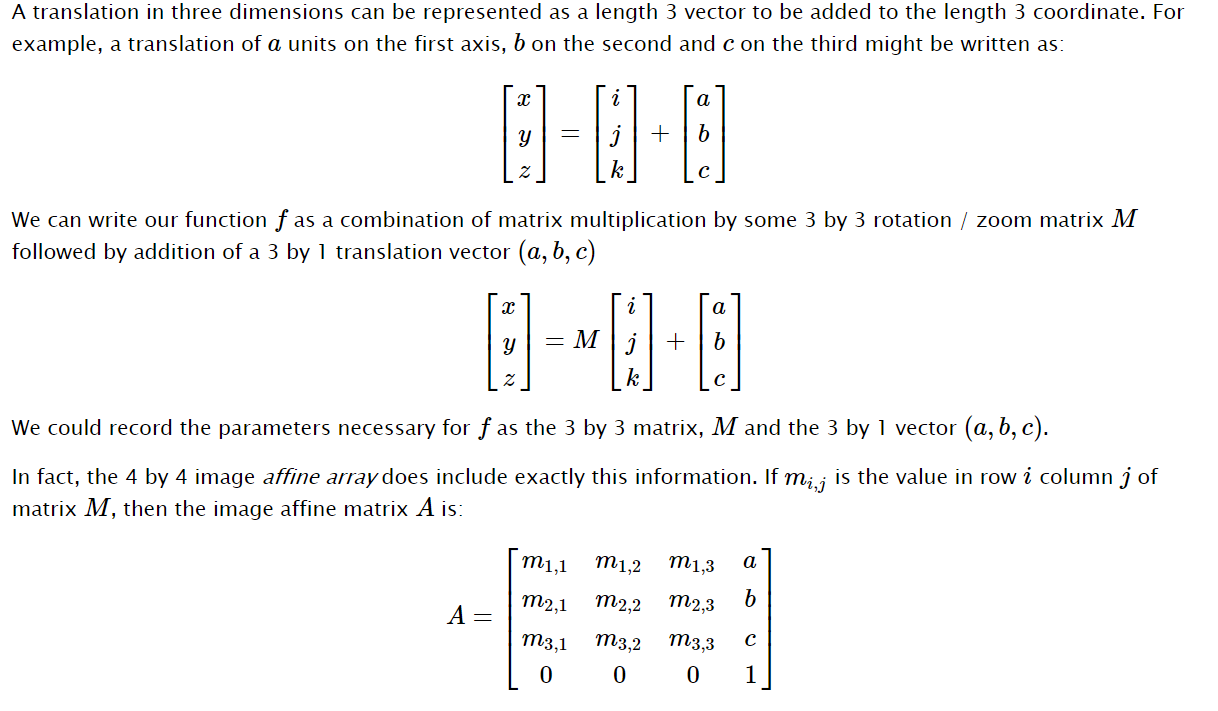

In [110]:
img.affine

array([[ -1.,  -0.,  -0.,   0.],
       [ -0.,  -1.,  -0., 239.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.]])

In [121]:
t1_file = os.path.join(os.getcwd(), 'BraTS20_Training_001_t1.nii.gz')
t1ce_file = os.path.join(os.getcwd(), 'BraTS20_Training_001_t1ce.nii.gz')
seg_file = os.path.join(os.getcwd(), 'BraTS20_Training_001_seg.nii.gz')
t2_file = os.path.join(os.getcwd(), 'BraTS20_Training_001_t2.nii.gz')
flair_file = os.path.join(os.getcwd(), 'BraTS20_Training_001_flair.nii.gz')

In [122]:
t1 = nib.load(t1_file)
t1ce = nib.load(t1ce_file)
seg = nib.load(seg_file)
t2 = nib.load(t2_file)
flair = nib.load(flair_file)

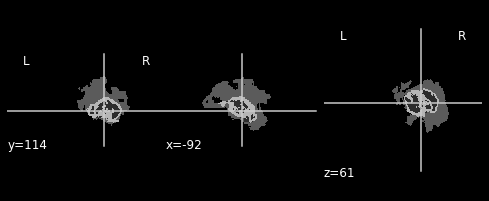

In [126]:
plotting.plot_anat(seg)

In [135]:
seg_data = seg.get_fdata()
t1_data = t1.get_fdata()
seg_data.shape
t1_data.shape

(240, 240, 155)

Text(0.5, 0.98, 'Center slices for EPI image')

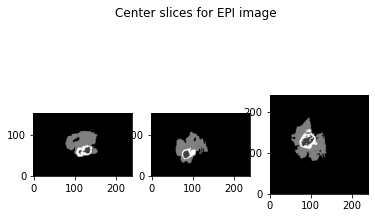

In [129]:
slice_0 = seg_data[106, :, :]
slice_1 = seg_data[:, 106, :]
slice_2 = seg_data[:, :, 70]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

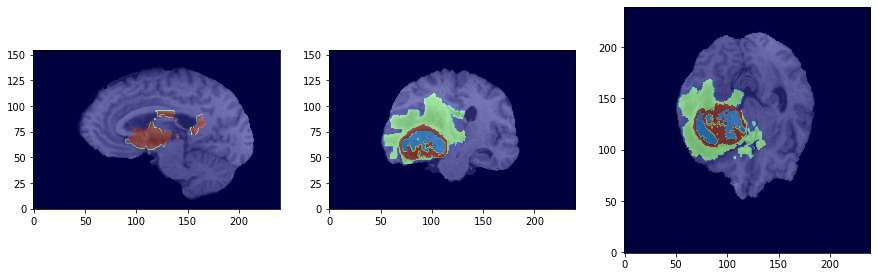

In [152]:
slice_x = 130
slice_y = 130
slice_z = 60

seg_slice_x = seg_data[slice_x, :, :]
t1_slice_x = t1_data[slice_x, :, :]
seg_slice_y = seg_data[:,slice_y, :]
t1_slice_y = t1_data[ :,slice_y, :]
seg_slice_z = seg_data[:, :, slice_z]
t1_slice_z = t1_data[:, :,slice_z,]

figs, axs = plt.subplots(1,3,figsize=(15,7))
axs[0].imshow(seg_slice_x.T, cmap="jet", origin="lower")
axs[0].imshow(t1_slice_x.T, cmap="gray", origin="lower",alpha=0.5)
axs[1].imshow(seg_slice_y.T, cmap="jet", origin="lower")
axs[1].imshow(t1_slice_y.T, cmap="gray", origin="lower",alpha=0.5)
axs[2].imshow(seg_slice_z.T, cmap="jet", origin="lower")
axs[2].imshow(t1_slice_z.T, cmap="gray", origin="lower",alpha=0.5)